## Experiment 4 - CNN not centered, without silence

- [ ] librosa has a functionality to remove noise from wav files -> Create a train/test folder with wav files that don't have silences
- [ ] Split the wav files in 5 seconds windows that overlap by 1.5 seconds and train on that, at testing do the same and get the mean of each category




### Interesting notes

https://musicinformationretrieval.com/


In [1]:
## Remove files that are corrupted in audio_test

import os
import os.path
from os.path import basename

import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import glob

import librosa
import librosa.display
import librosa.effects
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder

from tensorboardX import SummaryWriter
import pickle

%matplotlib inline

for file in ['audio_test/0b0427e2.wav', 'audio_test/6ea0099f.wav', 'audio_test/b39975f5.wav']:
    if os.path.isfile(file):
        os.remove(file)


In [2]:
def read_csv():
    ## Read the CSV file
    df = pd.read_csv('train.csv')
    df['label'] = df['label'].astype('category')
    
    return df


def split_train_val_small(df):
    ## Create a BIG train dataset and a validation
    train, validation = train_test_split(df, test_size=1500, random_state=1, stratify=df['label'])

    ## from the big train, we create a small one to make fastest computations
    _, small = train_test_split(train, test_size=1500, random_state=1, stratify=train['label'])

    return train, validation, small


def plot_categorical_variable_distribution(serie, ax, title="Distribution", order = None):
    count  = serie.value_counts(normalize=True)
    ax.set_title(title)
    sns.barplot(count.index, count.values, alpha=0.8, order=order, ax=ax)

    
def visualize_distribution_train_validation_small(train, validation, small):
    ## Print the repetition of each class, to be sure that the distribution is acceptable for validation and small sets
    fig, axes = plt.subplots(3, 1, figsize=(20, 20))
    order = train['label'].value_counts().index

    plot_categorical_variable_distribution(train['label'], axes.flat[0], title= "All training", order=order)
    plot_categorical_variable_distribution(validation['label'], axes.flat[1], title= "Validation", order=order)
    plot_categorical_variable_distribution(small['label'], axes.flat[2], title = "Small", order=order)



#df = read_csv()
#train, val, small = split_train_val_small(df)
#visualize_distribution_train_validation_small(train, val, small)

## process audio

1. for each filename
   1. Load it
   2. Pass a windows of 5 seconds with an overlap of 1.5 secs
   3. If the clip is shorter than 5 secs, repeat the all the clip until fill the 5 secs



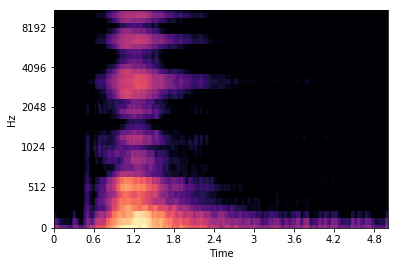

In [3]:
## Load wavefiles and calculate some features


def load_signal(filename):
    return librosa.load(filename, res_type='kaiser_fast' )

def load_without_silence(filename):
    signal, sr = load_signal(filename)
    signal, index = librosa.effects.trim(signal)
    return signal, sr

def repeat_signal_if_not_long_enough(signal, center_duration ):
    """
    
    """
    duration = signal.shape[0]

    if duration < center_duration:
        n_repeat = math.ceil(center_duration / duration)
        signal = np.repeat(signal, n_repeat)
        
    return signal
    
def sliding_window(signal, sr, window_size, overlap=1.5):
    window_size = int(window_size * sr)
    overlap = int(overlap * sr)
    
    start = 0
    while True:
        end = start + window_size

        if end > len(signal):
            yield repeat_signal_if_not_long_enough(signal[start:], window_size)[0: window_size]
            break
        
        yield signal[start:end]
        
        start = start + (window_size - overlap)

def get_features_for_signal(signal, sr):
    signal = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40)    
    return librosa.power_to_db(signal, ref=np.max)


def get_features_for_file(filename, seconds = 5):
    signal, sr = load_without_silence(filename)
    
    signals = sliding_window(signal, sr, seconds)
    return [get_features_for_signal(signal, sr) for signal in signals]


def show_spectogram(filename):
    p = get_features_for_file(filename)
    for x in p:
        librosa.display.specshow(x,y_axis='mel', x_axis='time')

def show_audio(filename):
    import IPython.display as ipd
    return ipd.Audio(filename)


filename = "audio_train/18e0f7ac.wav"

show_spectogram(filename)
show_audio(filename)


# Generate features

We create 4 x,y

`x`,`y` -> small dataset

`x_validation`, `y_validation`

`x_full`, `y_full`

`x_test`

In [4]:
## for each filename get the 
def get_features(x, y):
    """
    Merges the multiple clips of one sound to the single label
    
    What we do is repeat the single label as many times as clips we have
    """
    x = [get_features_for_file(filename) for filename in x]
    if type(y) == list:
        y = [[y] * len(clips) for clips, y in zip(x, y)]
        y = [item for sublist in y for item in sublist]
    else:
        y = [np.array(y).repeat(len(clips)) for clips, y in zip(x, y)]
        y = np.hstack(y)

    x = np.vstack(x)

    return x, y


def process_csv(data, file):
    """
    Loads the wavfiles from each row
    Transforms them
    """
    
    x = data['fname']
    x = map(lambda f: "audio_train/" + f, x.values)
    y = np.array(data['label'].cat.codes)

    x_file = file + "_x.npy"
    y_file = file + "_y.npy"
    exist_cache_x = os.path.isfile(x_file)
    exist_cache_y = os.path.isfile(y_file)
    print(exist_cache_x, exist_cache_y, file)
    if not (exist_cache_x and exist_cache_y):
        x, y = get_features(x, y)
        np.save(x_file, x)
        np.save(y_file, y)
    else:
        x = np.load(x_file)    
        y = np.load(y_file) 
    
    return x, y


def load_test(filename):
    x_file = filename + "_x.npy"
    y_file = filename + "_y.npy"
    exist_cache_x = os.path.isfile(x_file)
    exist_cache_y = os.path.isfile(y_file)
    
    if not (exist_cache_x and exist_cache_y):
        x, y = get_features(test_files, test_files)
        np.save(x_file, x)
        with open(y_file, 'wb') as fp:
            pickle.dump(y, fp)
        
    else:
        x = np.load(x_file)
        with open (y_file, 'rb') as fp:
            y = pickle.load(fp)
    return x, y


## Simple CNN - Only Dense layer

Create the simplest model with just 2 Full Connected layers


In [5]:
class Net_old(nn.Module):
    def __init__(self):
        super(Net_old, self).__init__()
        self.con1 = nn.Conv1d(40, 80, 3)
        self.maxpool1 = nn.MaxPool1d(3, stride=2)
        self.con2 = nn.Conv1d(80, 160, 3)
        self.con2_bn = nn.BatchNorm1d(160)

        self.fc1 = nn.Linear(8160, 4000)
        self.fc1_bn = nn.BatchNorm1d(4000)
        self.fc2 = nn.Linear(4000, 2000)
        self.fc2_bn = nn.BatchNorm1d(2000)
        self.fc3 = nn.Linear(2000, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc4_bn = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, 41)

    def forward(self, x):
        
        x = self.con1(x)
        x = self.maxpool1(x)
        x = self.con2(x)
        x = self.con2_bn(x)
        x = self.maxpool1(x)
        x = x.view(-1, 8160)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.relu(self.fc4_bn(self.fc4(x)))

        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)


# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = Net_2D().to(device)

#num_paramets = sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(model, num_paramets)

In [6]:

class Net_1D(nn.Module):
    def __init__(self):
        super(Net_1D, self).__init__()
        self.conv1 = nn.Conv1d(40, 80, kernel_size=5)
        self.conv2 = nn.Conv1d(80, 160, kernel_size=5)
        self.conv2_drop = nn.Dropout()
        self.fc1 = nn.Linear(8160, 4000)
        
        self.fc2 = nn.Linear(4000, 1000)
        self.fc3 = nn.Linear(1000, 41)

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 8160)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [7]:
class Net_2D(nn.Module):
    def __init__(self):
        super(Net_2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 40, 3)
        self.conv2_bn = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 50, 3)
        self.conv3_bn = nn.BatchNorm2d(50)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(3750, 2000)        
        self.fc2 = nn.Linear(2000, 512)
        self.fc3 = nn.Linear(512, 41)

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
        x = F.relu(F.max_pool2d(self.conv1_bn(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_bn(self.conv3(x)), 2))

        x = x.view(-1, 3750)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


## Creating datasets 

Pytorch uses datasets and loaders for creating mini batches

In [8]:
def convert_categorical_to_one_hot(y):
    return pd.get_dummies(y).values

def create_dataset(x, y):
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y.astype(np.uint8)).long()
    
    return TensorDataset(x, y)

class TestDataset(Dataset):

    def __init__(self, x, y):
        assert len(x) == len(y)
        self.data = (x, y)

    def __getitem__(self, index):
        return tuple(data[index] for data in self.data)

    def __len__(self):
        return len(self.data[0])
    

#BATCH_SIZE = 750

#small = create_dataset(x, y)
#validation = create_dataset(x_validation, y_validation)
#full = create_dataset(x_full, y_full)
#test = TensorDataset(torch.from_numpy(x_test))

#small_loader = torch.utils.data.DataLoader(small, batch_size=BATCH_SIZE, shuffle=True)
#validation_loader = torch.utils.data.DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
#full_loader = torch.utils.data.DataLoader(full, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)


In [9]:

def train(model, device, train_loader, optimizer, epoch, log_interval = 10):
    model.train()
    total_loss = 0
    iterations = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        iterations += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        total_loss += loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return total_loss / float(iterations)
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


## On kaggle the function used is MapK@3

In [10]:
import ml_metrics as metrics

def predict_probabilities(x):
    with torch.no_grad():
        if type(x) == torch.Tensor:
            x = x.float().to(device)
        else:
            x = torch.from_numpy(x).float().to(device)
        output = model(x)
        output = output.cpu().detach().numpy()
        return output

def probabilities_to_indices(probs):
    return np.argsort(-probs)
    
def predict(x):
    output = predict_probabilities(x)
    indices = probabilities_to_indices(output)
    return indices


def get_top_predict(indices, k=3):
    return list(map(lambda row: [row[0], row[1], row[2]], indices))

def score(loader):
    actual_y = []
    y_hat = []
    
    for x,y in loader:
        indices = predict(x)
        top3_predict = get_top_predict(indices, k=3)
        y_hat = y_hat + top3_predict
        
        actual_y = actual_y + [[y] for y in y.numpy().tolist()]

    return metrics.mapk(actual_y, y_hat, 3)


In [11]:
def generate_csv(test_loader, filename, df):

    # Step 1: get the probabilities of each "clip" along with the filename on it is generated
    probabilities = []
    labels = []

    for data, label_batch in test_loader:
        probs = predict_probabilities(data)
        probabilities.append(probs)
        labels = labels + list(label_batch)

    probabilities = np.vstack(probabilities)

    # Step 2: reduce the labels and the probabilities
    # probabilities: array with the filename and the mean of probabilities of each clip in the filename
    grouped = {}

    for index, label in enumerate(labels):
        if label not in grouped:
            grouped[label] = []

        grouped[label].append(probabilities[index])

    probabilities = [(label, np.mean(np.vstack(v), axis=0)) for label, v in grouped.items()]

    # Step 3: convert to indices
    probabilities = [(label, probabilities_to_indices(probs)) for label, probs in probabilities]

    # Step 4: put categories strings instead of indexes
    categories = {i: x for (i,x) in enumerate(df['label'].cat.categories) }
    def get_top_label_string(indices):
        return "%s %s %s" % (categories[indices[0]], categories[indices[1]], categories[indices[2]])
    
    probabilities = [(label, get_top_label_string(p)) for label, p in probabilities]
    
    submission = pd.DataFrame(
        {'fname': [basename(filename) for filename, p in probabilities],
         'label': [labels for filename, labels in probabilities]
        })

    missing_data = pd.DataFrame(
        {'fname': ['0b0427e2.wav', '6ea0099f.wav', 'b39975f5.wav'],
         'label': 3 * ['Laughter Hi-Hat Flute']
        })

    submission = submission.append(missing_data, ignore_index=True)

    if os.path.isfile(filename):
        os.remove(filename)

    submission.to_csv(filename, index=False)


In [12]:
from sklearn.metrics import confusion_matrix

def get_actuals_and_predictions(model, loader):
    pred_y = []
    real_y = []

    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred_y = pred_y + output.max(1, keepdim=True)[1].tolist()
            real_y = real_y + target.tolist()

    pred_y = [y for x in pred_y for y in x] ## flatten
    return (real_y, pred_y)

def calc_confusion_matrix(model, loader):
    get_actuals_and_predictions(model, loader)
    return confusion_matrix(real_y, pred_y)

def plot_confusion_matrix(model, loader):
    return sns.heatmap(calc_confusion_matrix(model, validation_loader))
    


# Start training

we are using TensorBoardX to send the losses and see nices charts :)

`tensorboard --logdir runs`

In [13]:
args = {
    'optimizer': lambda model: optim.RMSprop(model.parameters(), lr=0.00001, momentum = 0.90),
    'epochs': 100,
    'model': lambda: Net_2D(),
    'small': True,
    'batch_size': 1000,
    'EXPERIMENT_NAME': 'cnn-window/',
    'NAME': '2D',
    'model_filename': 'cnn-window/model'
    
}

small = args['small']
EXPERIMENT_NAME = args['EXPERIMENT_NAME']
BATCH_SIZE = args['batch_size']
EPOCHS = args['epochs']


print("Reading CSV")
df = read_csv()
train_data, validation, small = split_train_val_small(df)
test_files = glob.glob("audio_test/*.wav")

print("Loading data into numpy")
x, y = process_csv(small, "%s/small_x.npy" % EXPERIMENT_NAME)
x_validation, y_validation = process_csv(validation, "%s/validation_x.npy" % EXPERIMENT_NAME)
x_full, y_full = process_csv(train_data, "%s/full_x.npy" % EXPERIMENT_NAME)
x_test, y_test = load_test("%s/test.npy" % EXPERIMENT_NAME)

print("Create a Pytorch Dataset")
small_dataset = create_dataset(x, y)
validation_dataset = create_dataset(x_validation, y_validation)
full_dataset = create_dataset(x_full, y_full)
test_dataset = TestDataset(x_test, y_test)

print("Create a Pytorch DataLoader")
small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


Reading CSV
Loading data into numpy
True True cnn-window//small_x.npy
True True cnn-window//validation_x.npy
True True cnn-window//full_x.npy
Create a Pytorch Dataset
Create a Pytorch DataLoader


In [14]:


print("Creating model and optimizer")
model = args['model']()
model = model.to(device)

num_paramets = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model, num_paramets)

## Create the optimizer
optimizer = args['optimizer'](model)


writer = SummaryWriter()
prev_loss = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, device, full_loader, optimizer, epoch)
    validation_loss = test(model, device, validation_loader)
    s = score(validation_loader)
    #(real, pred) = get_actuals_and_predictions(model, validation_loader)
    
    writer.add_scalar('data/score', s, epoch)
    writer.add_scalars('loss', {
        'train': train_loss,
        'validation': validation_loss
    }, epoch)
    
    if not prev_loss or prev_loss > validation_loss:
        prev_loss = validation_loss
        print("Improved validation loss, saving model...")
        torch.save(model, args['model_filename'])



Creating model and optimizer
Net_2D(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5)
  (conv3_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=3750, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=41, bias=True)
) 8573255
Train Epoch: 1 [0/17212 (0%)]	Loss: 3.719908
Train Epoch: 1 [10000/17212 (56%)]	Loss: 3.263399

Test set: Average loss: 3.3990, Accuracy: 468/3317 (14%)

Improved validation loss, saving model...


/home/kozko/kaggle/freesound/venv/lib/python3.5/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net_2D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [0/17212 (0%)]	Loss: 3.133723
Train Epoch: 2 [10000/17212 (56%)]	Loss: 2.931016

Test set: Average loss: 2.9361, Accuracy: 709/3317 (21%)

Improved validation loss, saving model...
Train Epoch: 3 [0/17212 (0%)]	Loss: 2.865991
Train Epoch: 3 [10000/17212 (56%)]	Loss: 2.737066

Test set: Average loss: 2.6888, Accuracy: 892/3317 (27%)

Improved validation loss, saving model...
Train Epoch: 4 [0/17212 (0%)]	Loss: 2.657623
Train Epoch: 4 [10000/17212 (56%)]	Loss: 2.614333

Test set: Average loss: 2.5134, Accuracy: 1035/3317 (31%)

Improved validation loss, saving model...
Train Epoch: 5 [0/17212 (0%)]	Loss: 2.498150
Train Epoch: 5 [10000/17212 (56%)]	Loss: 2.527817

Test set: Average loss: 2.4347, Accuracy: 1094/3317 (33%)

Improved validation loss, saving model...
Train Epoch: 6 [0/17212 (0%)]	Loss: 2.383381
Train Epoch: 6 [10000/17212 (56%)]	Loss: 2.400168

Test set: Average loss: 2.3460, Accuracy: 1192/3317 (36%)

Improved validation loss, saving model...
Train Epoch: 7 [0

KeyboardInterrupt: 


## Prepare for submission!


In [ ]:
# Load best model
model = torch.load(args['model_filename']).to(device)
train_score = score(full_loader)
validation_score = score(validation_loader)

print("train score %s\nvalidation score %s" % (train_score, validation_score))

csv_filename = args['model_filename'] + ".csv"
generate_csv(test_loader, csv_filename, df)

In [ ]:
!kaggle competitions submit -c freesound-audio-tagging -f $csv_filename -m "CNN 2D with window"
